In [29]:
import scipy.signal
import numpy as np
import tclab
from scipy.linalg import block_diag
from tclab import TCLab, clock, Historian, Plotter, setup

In [30]:
import sympy
sympy.init_printing()

In [31]:
pip install tclab --upgrade

Requirement already up-to-date: tclab in c:\users\baral\anaconda3\lib\site-packages (0.4.9)
Note: you may need to restart the kernel to use updated packages.


In [32]:
#Effect of Q1 on T1

num1 = 0.69627052016 #K
den1 = [199.586477912, 1] #(tau*s+1)

G11 = scipy.signal.lti(num1, den1)
G11

TransferFunctionContinuous(
array([0.00348857]),
array([1.        , 0.00501036]),
dt: None
)

In [33]:
#Effect of Q2 on T2

num2 = 0.152409786038 #K
den2 = [217.282766993, 1] #(tau*s+1)

G22 = scipy.signal.lti(num2, den2)

In [34]:
#Effect of Q1 on T2
num3 = 0.158103632558 #K
den3 = np.convolve([145.106952068, 1], [147.075555312, 1])  #(tau1*s+1)*(tau2*s+1)


G21 = scipy.signal.lti(num3, den3)

In [35]:
#Effect of Q2 on T1
num4 = 0.100790375 #K
den4 = np.convolve([184.668159, 1], [142.999742, 1]) #(tau1*s+1)*(tau2*s+1)

G12 = scipy.signal.lti(num4, den4)

In [36]:
G11ss = G11.to_ss()
G12ss = G12.to_ss()
G21ss = G21.to_ss()
G22ss = G22.to_ss()

A11 = G11ss.A
B11 = G11ss.B
C11 = G11ss.C
D11 = G11ss.D

A12 = G12ss.A
B12 = G12ss.B
C12 = G12ss.C
D12 = G12ss.D

A21 = G21ss.A
B21 = G21ss.B
C21 = G21ss.C
D21 = G21ss.D

A22 = G22ss.A
B22 = G22ss.B
C22 = G22ss.C
D22 = G22ss.D



In [37]:
A = block_diag(A11, A12, A21, A22)

B1h = block_diag(B11, B12)
B2h = block_diag(B21, B22)
B = np.vstack((B1h, B2h))

C1h = np.hstack((C11, C12))
C2h = np.hstack((C21, C22))
C = block_diag(C1h, C2h)

D1h = np.hstack((D11, D12))
D2h = np.hstack((D21, D22))
D = np.vstack((D1h, D2h))

A
x= np.zeros((A.shape[0],1))



In [38]:
M0 = 0
M1 = 100
M2 = 0
ts1 = 30
ts2 = 900

In [39]:
def Q_step(t, M0, M1, ts1):
    if t < ts1:
        return M0
    
    else:
        return M1

In [40]:
def Temp(t, T1o, T2o):
    
    tspan = np.linspace(0, t, 1000)
    dt = tspan[1]-tspan[0]
    
    x = np.zeros((A.shape[0],1))
    
    for i in np.arange(0, len(tspan), 1):
    
        Q1 = Q_step(t, M0, M1, ts1)
        Q2 =  0

        Q = np.array([[Q1], [Q2]])

        dxdt = A.dot(x) + B.dot(Q)
        y = C.dot(x) + D.dot(Q)
        
        x = x + dxdt*dt

        T1 = y[0,0] + T1o
        T2 = y[1,0] + T2o
    
    return [T1, T2]

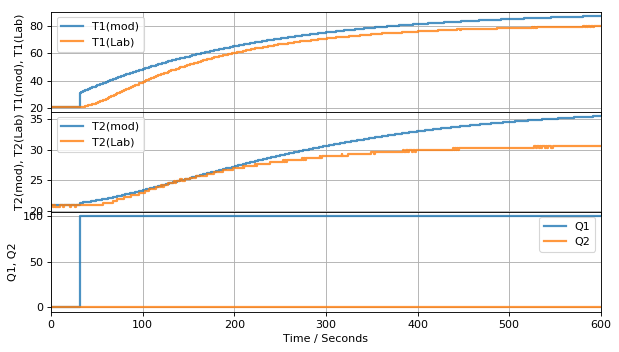

TCLab Model disconnected successfully.


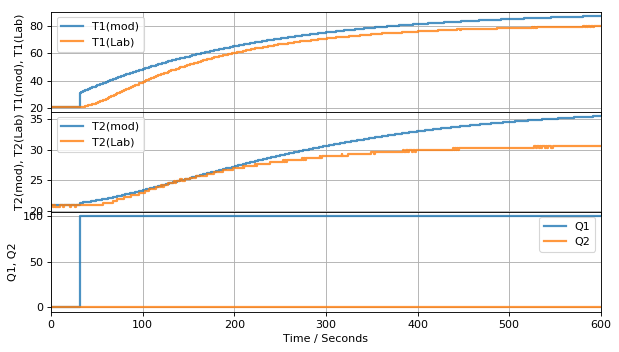

In [41]:
TCLab = tclab.setup(connected = False)
t_run = 600

with TCLab() as lab:

    T1o = 21
    T2o = 21
    
    sources = [('T1(mod)', lambda: Temp(t,T1o, T2o)[0]), ('T2(mod)', lambda: Temp(t,T1o,T2o)[1]),
               ('T1(Lab)', lambda: lab.T1), ('T2(Lab)', lambda: lab.T2),
              ('Q1', lambda: lab.Q1()), ('Q2', lambda: lab.Q2())]

    h = tclab.Historian(sources)
    
    p = Plotter(h, twindow=t_run, layout = (('T1(mod)', 'T1(Lab)'),
                                          ('T2(mod)', 'T2(Lab)'),
                                          ('Q1', 'Q2')))
    
    for t in clock(t_run): 
        Q1 = Q_step(t, M0, M1, ts1)
        Q2 = 0
        lab.Q1(Q1)
        lab.Q2(Q2)
        
        p.update(t)